##### Master Degree in Computer Science and Data Science for Economics

# Quick introduction to neural networks as functions approximators

### Alfio Ferrara

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import torch.nn as nn
import torch

## Define a function that we want to approximate

In [3]:
import matplotlib.pyplot as plt

In [4]:
f_x = lambda x: np.sin(x) - (x**2 / 40)

In [8]:
X = np.arange(-5, 5, .1)
X

array([-5.00000000e+00, -4.90000000e+00, -4.80000000e+00, -4.70000000e+00,
       -4.60000000e+00, -4.50000000e+00, -4.40000000e+00, -4.30000000e+00,
       -4.20000000e+00, -4.10000000e+00, -4.00000000e+00, -3.90000000e+00,
       -3.80000000e+00, -3.70000000e+00, -3.60000000e+00, -3.50000000e+00,
       -3.40000000e+00, -3.30000000e+00, -3.20000000e+00, -3.10000000e+00,
       -3.00000000e+00, -2.90000000e+00, -2.80000000e+00, -2.70000000e+00,
       -2.60000000e+00, -2.50000000e+00, -2.40000000e+00, -2.30000000e+00,
       -2.20000000e+00, -2.10000000e+00, -2.00000000e+00, -1.90000000e+00,
       -1.80000000e+00, -1.70000000e+00, -1.60000000e+00, -1.50000000e+00,
       -1.40000000e+00, -1.30000000e+00, -1.20000000e+00, -1.10000000e+00,
       -1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -1.77635684e-14,  1.00000000e-01,
        2.00000000e-01,  

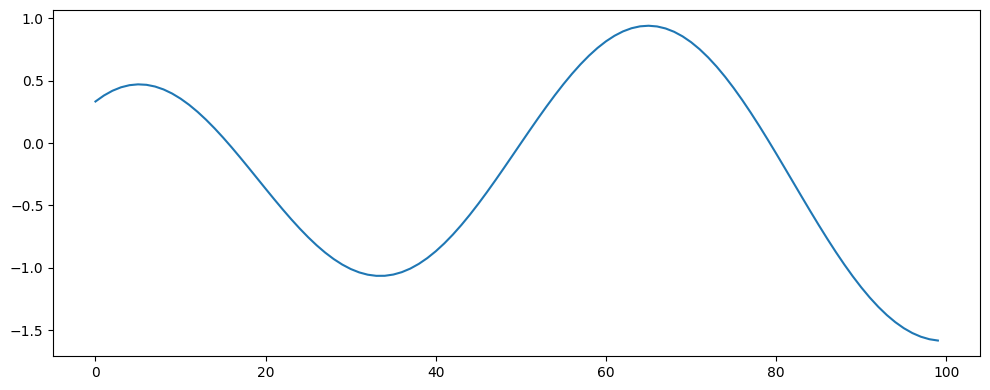

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(f_x(X))
plt.tight_layout()
plt.show()

## Use a NN to learn the function

In [10]:
#in pytorch each NN is a subclass of nn.Module
class SigmoidNeuralNet(nn.Module):
    """Double-layer neural network with sigmoid activation."""
    '''
    The sigmoid function is primarily used in the output layer of binary classification models
    where you need a probability output. It is generally not recommended for hidden layers in deep neural
    networks due to the vanishing gradient problem (During backpropagation (weights/bias update per loss),
    the gradient becomes close to zero causing inefficient learning phase).
    '''
    def __init__(self, num_features, nodes=4):
        super().__init__()
        #in case of NGLM we may introduce word embedding as an initial layer
        self.layer1  = nn.Linear(in_features=num_features, out_features=nodes)
        self.layer2  = nn.Linear(in_features=nodes, out_features=num_features)
        self.sigmoid = nn.Sigmoid()

    #calculates how the propagation happens over layers through activation function till the output
    def forward(self, inputs):
        logits1 = self.layer1(inputs)
        activations = self.sigmoid(logits1)
        output = self.layer2(activations)
        return output

In [11]:
class ReluNeuralNet(nn.Module):
    """Double-layer neural network with Relu activation."""
    '''
    ReLU [ReLU(x) = max(0, x)] has become the default activation function for most hidden layers in deep neural networks,
    especially in convolutional neural networks (CNNs) and many other deep learning architectures.
    Its ability to combat the vanishing gradient problem and its computational efficiency.
    In modern deep learning, ReLU and its variants (like Leaky ReLU, PReLU, ELU, GELU) are generally
    preferred for hidden layers due to their ability to mitigate the vanishing gradient problem
    and improve training speed.
    '''
    def __init__(self, num_features, nodes=4):
        super().__init__()
        self.layer1  = nn.Linear(in_features=num_features, out_features=nodes)
        self.layer2  = nn.Linear(in_features=nodes, out_features=num_features)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        logits1 = self.layer1(inputs)
        activations = self.relu(logits1)
        output = self.layer2(activations)
        return output

In [12]:
inputs = torch.randint(-10, 10, (2000, 1)).float() #returns shape of 2000x1 of the passed range
num_features = inputs.size(-1) #the last dimension in shape[...]
model = SigmoidNeuralNet(num_features, nodes=4)
#model = ReluNeuralNet(num_features, nodes=4)

In [13]:
inputs

tensor([[ 0.],
        [ 9.],
        [-2.],
        ...,
        [ 1.],
        [-8.],
        [ 8.]])

In [14]:
prediction = model(inputs)

In [15]:
prediction

tensor([[-0.4095],
        [-0.7261],
        [-0.2521],
        ...,
        [-0.5060],
        [-0.0932],
        [-0.7203]], grad_fn=<AddmmBackward0>)

### Training

In [16]:
targets = f_x(inputs)

/tmp/ipython-input-1164241505.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f_x = lambda x: np.sin(x) - (x**2 / 40)


In [17]:
targets

tensor([[ 0.0000],
        [-1.6129],
        [-1.0093],
        ...,
        [ 0.8165],
        [-2.5894],
        [-0.6106]])

#### Loss function

In [18]:
from torch.nn import MSELoss

In [19]:
loss = MSELoss()
error = loss(prediction, targets)
error

tensor(1.3409, grad_fn=<MseLossBackward0>)

#### Optimizer for gradient descent

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) #stocastic gradient descent

#### Data management

In [22]:
from torch.utils.data import Dataset, DataLoader

In [23]:
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.x = inputs
        self.y = targets

    def __len__(self):
        return self.x.size(0)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

In [24]:
dataset = CustomDataset(inputs, targets)
dataset[1]

(tensor([9.]), tensor([-1.6129]))

**Dataloader**: Using a dataloader we can define how the network will read the data and how often parameters will be updated (batch approach)

In [25]:
dataloader = DataLoader(dataset, batch_size=10, drop_last=False, shuffle=False)

In [26]:
for i, batch in enumerate(dataloader):
    print(f"batch {i}: x: {batch[0]}, y: {batch[1]}")
    if i > 5:
        break

batch 0: x: tensor([[  0.],
        [  9.],
        [ -2.],
        [  9.],
        [-10.],
        [ -8.],
        [-10.],
        [ -7.],
        [  2.],
        [ -8.]]), y: tensor([[ 0.0000],
        [-1.6129],
        [-1.0093],
        [-1.6129],
        [-1.9560],
        [-2.5894],
        [-1.9560],
        [-1.8820],
        [ 0.8093],
        [-2.5894]])
batch 1: x: tensor([[ -2.],
        [-10.],
        [ -5.],
        [ -9.],
        [  5.],
        [ -2.],
        [  5.],
        [  8.],
        [  8.],
        [ -9.]]), y: tensor([[-1.0093],
        [-1.9560],
        [ 0.3339],
        [-2.4371],
        [-1.5839],
        [-1.0093],
        [-1.5839],
        [-0.6106],
        [-0.6106],
        [-2.4371]])
batch 2: x: tensor([[-5.],
        [ 8.],
        [ 0.],
        [-4.],
        [-3.],
        [ 5.],
        [ 9.],
        [-6.],
        [ 3.],
        [-8.]]), y: tensor([[ 0.3339],
        [-0.6106],
        [ 0.0000],
        [ 0.3568],
        [-0.3661],
  

In [27]:
dataloader = DataLoader(dataset, batch_size=10, drop_last=False, shuffle=False)

### Training routine

In [28]:
epochs = 500

mean_error = []
predictions = []

run = list(range(epochs))

for epoch in tqdm(run):
    errors = []
    for batch in dataloader:
        # step 0: get the data and the correct target
        features, target = batch
        # step 1: use the model for prediction (forward pass)
        y_pred = model(features)
        # step 2: measure the error by comparing the predictions to the expected outputs
        error = loss(y_pred, target)
        # step 3: backprop the loss signal through the graph, notifying each parameter of its gradient
        error.backward()
        # step 4: update model parameters using the gradient
        optimizer.step()
        # step 5: clear the previously computed gradients stored inside the model
        model.zero_grad()
        # step 6: reporting
        errors.append(error.item())
    mean_error.append(np.array(errors).mean())
    prediction_on_target = model(torch.tensor(X.reshape(-1, 1)).float()).detach().numpy().ravel()
    predictions.append(prediction_on_target)

  0%|          | 0/500 [00:00<?, ?it/s]

### Learning process

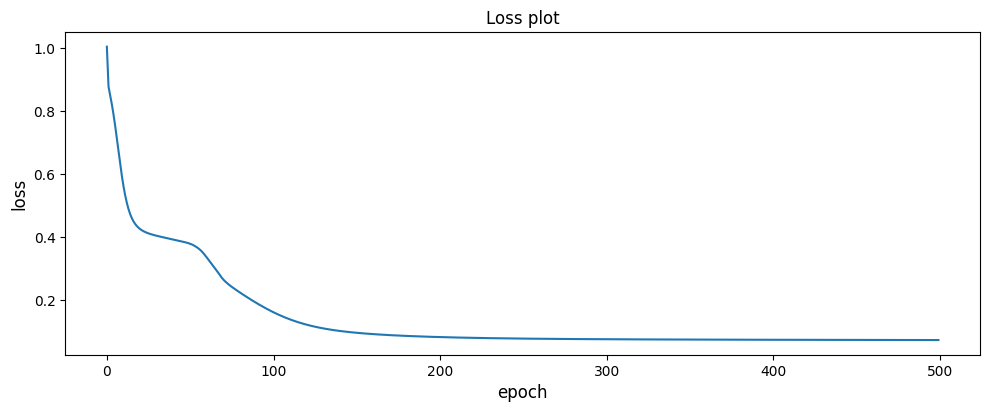

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(mean_error)
plt.xlabel('epoch', size=12)
plt.ylabel('loss', size=12)
plt.tight_layout()
plt.title("Loss plot")
plt.show()

### Fit procedure

In [35]:
from IPython.display import clear_output

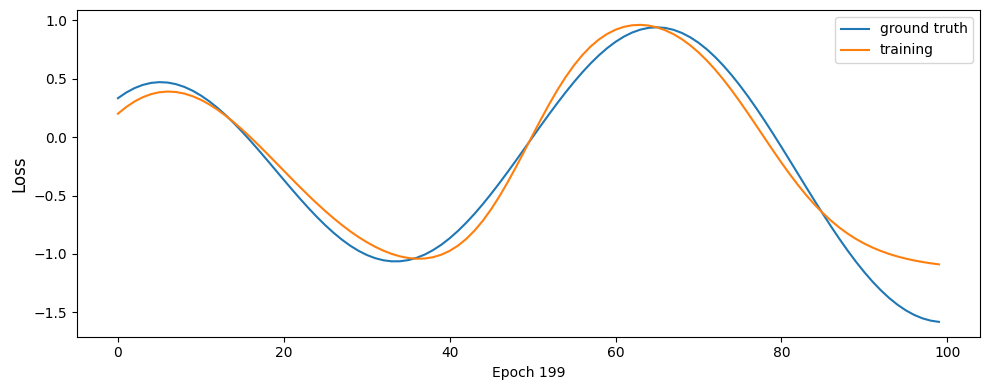

In [40]:
#View how training and validation loss curves evolve over epochs
for i, y_pred in enumerate(predictions[:200]):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(f_x(X))
    ax.plot(y_pred)
    ax.set_ylabel('Loss', size=12)
    ax.set_xlabel('Epoch {}'.format(i))
    plt.tight_layout()
    plt.legend(['ground truth', 'training'])
    plt.show()